In this notebook, we will go through following topics:

- Feature Engineering
- Neural Network Creation
- Strategy Backtesting

The focus of this lab would be to understand the implementation of neural networks using the scikit learn library. To do so, we will start with importing necessary libraries.

## Part 1 - Training a neural network

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
sns.set()

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# Loading the data from the local file
df = pd.read_csv('EURUSD_data.csv', index_col=0, parse_dates=True)

In [3]:
# Copying the original dataframe. Will work on the new dataframe.
data = df.copy()
# Checking the shape
print('Number of observations:', data.shape[0])
print('Number of variables:', data.shape[1])

Number of observations: 2343
Number of variables: 6


### Feature Engineering

In [4]:
# Creating features
features_list = []

# SD based features
for i in range(5, 20, 5):
    col_name = 'std_' + str(i)
    data[col_name] = data['Close'].rolling(window=i).std()
    features_list.append(col_name)
    
# MA based features
for i in range(10, 30, 5):
    col_name = 'ma_' + str(i)
    data[col_name] = data['Close'].rolling(window=i).mean()
    features_list.append(col_name)
    
# Daily pct change based features
for i in range(3, 12, 3):
    col_name = 'pct_' + str(i)
    data[col_name] = data['Close'].pct_change().rolling(i).sum()
    features_list.append(col_name)
    
# Intraday movement
col_name = 'co'
data[col_name] = data['Close'] - data['Open']
features_list.append(col_name)

In addition, We'll use popular technical indicators to build features. They are as follows:

- [Bolling Bands](https://en.wikipedia.org/wiki/Bollinger_Bands)
- [Moving Average Cross Over (MACD)](https://en.wikipedia.org/wiki/MACD)
- [Parabolic Stop And Reverse (SAR)](https://en.wikipedia.org/wiki/Parabolic_SAR)


The discussion about what these technical indicators and how they are built, is out of scope of this session. We'll use `TA-LIB` library to build these indicators.

In [5]:
import talib as ta

In [6]:
data['upper_band'], data['middle_band'], data['lower_band'] = ta.BBANDS(data['Close'].values)
data['macd'], data['macdsignal'], data['macdhist'] = ta.MACD(data['Close'].values)
data['sar'] = ta.SAR(data['High'].values, data['Low'].values)
features_list +=['upper_band','middle_band','lower_band','macd','sar']

ML algorithms don't work with `NaN` values. However, while creating the above features, we would have many `NaN` values we need to drop from our dataset.

In [7]:
features_list

['std_5',
 'std_10',
 'std_15',
 'ma_10',
 'ma_15',
 'ma_20',
 'ma_25',
 'pct_3',
 'pct_6',
 'pct_9',
 'co',
 'upper_band',
 'middle_band',
 'lower_band',
 'macd',
 'sar']

In [8]:
data[features_list].head()

std_5  std_10  std_15  ma_10  ma_15  ma_20  ma_25     pct_3  \
Date                                                                         
2009-12-31       NaN     NaN     NaN    NaN    NaN    NaN    NaN       NaN   
2010-01-01       NaN     NaN     NaN    NaN    NaN    NaN    NaN       NaN   
2010-01-04       NaN     NaN     NaN    NaN    NaN    NaN    NaN       NaN   
2010-01-05       NaN     NaN     NaN    NaN    NaN    NaN    NaN  0.002732   
2010-01-06  0.003737     NaN     NaN    NaN    NaN    NaN    NaN  0.000993   

            pct_6  pct_9        co  upper_band  middle_band  lower_band  macd  \
Date                                                                            
2009-12-31    NaN    NaN -0.001500         NaN          NaN         NaN   NaN   
2010-01-01    NaN    NaN  0.006288         NaN          NaN         NaN   NaN   
2010-01-04    NaN    NaN  0.011394         NaN          NaN         NaN   NaN   
2010-01-05    NaN    NaN -0.006114         NaN          NaN         NaN   NaN   
2010-01-06    NaN    NaN  0.003807    1.444904     1.438219    1.431534   NaN   

                 sar  
Date                  
2009-12-31       NaN  
2010-01-01  1.431045  
2010-01-04  1.445191  
2010-01-05  1.426208  
2010-01-06  1.426208

There are null values in many columns. Let's drop them.

In [9]:
data.dropna(inplace=True)

In [10]:
data[features_list].head()

std_5    std_10    std_15     ma_10     ma_15     ma_20  \
Date                                                                     
2010-02-16  0.007174  0.008744  0.013772  1.372029  1.379814  1.387765   
2010-02-17  0.006823  0.006695  0.012981  1.369088  1.376987  1.385247   
2010-02-18  0.010875  0.009546  0.014006  1.366253  1.373610  1.382070   
2010-02-19  0.010818  0.009634  0.013834  1.365603  1.371931  1.379440   
2010-02-22  0.010814  0.009766  0.012841  1.365113  1.369788  1.376718   

               ma_25     pct_3     pct_6     pct_9        co  upper_band  \
Date                                                                       
2010-02-16  1.398622  0.006298  0.008339 -0.009467  0.016979    1.381636   
2010-02-17  1.394954 -0.001914 -0.012626 -0.009872 -0.015846    1.378081   
2010-02-18  1.390800 -0.010262 -0.021224 -0.015841 -0.014914    1.380923   
2010-02-19  1.387697 -0.010913 -0.004615 -0.002574  0.014452    1.380425   
2010-02-22  1.384492  0.000027 -0.001887 -0.012599 -0.002337    1.380469   

            middle_band  lower_band      macd       sar  
Date                                                     
2010-02-16     1.368802    1.355968 -0.020450  1.353308  
2010-02-17     1.365875    1.353669 -0.020266  1.353797  
2010-02-18     1.361469    1.342016 -0.021051  1.378873  
2010-02-19     1.361072    1.341720 -0.020201  1.378873  
2010-02-22     1.361124    1.341779 -0.019380  1.378196

As OHLC data is high correlated, we won't be using them as features. Instead, we would use only technical indicators and quantitative features for this exercise. Below we define feature matrix `X`, create the target variable and assign it to the target vector `y`.

In [11]:
import numpy as np

In [12]:
X = data[features_list]
data['target'] = np.where(data['Close'].shift(-1) > data['Close'], 1, -1)
y = data['target']

We will use `train_test_split()` function from the `sklearn.model_selection` package to split our dataset. We will use 20% of our dataset as a test dataset.

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [46]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1848, 16), (462, 16), (1848,), (462,))

Before we can train our neural network, we need to make sure that our data is scaled, that is, it ranges between 0 and 1. We will use `StandardScaler` from the `sklearn.preprocessing` package. We need to train the scaler object on training data only and then apply on training and testing set both.

In [47]:
from sklearn.preprocessing import StandardScaler

In [48]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

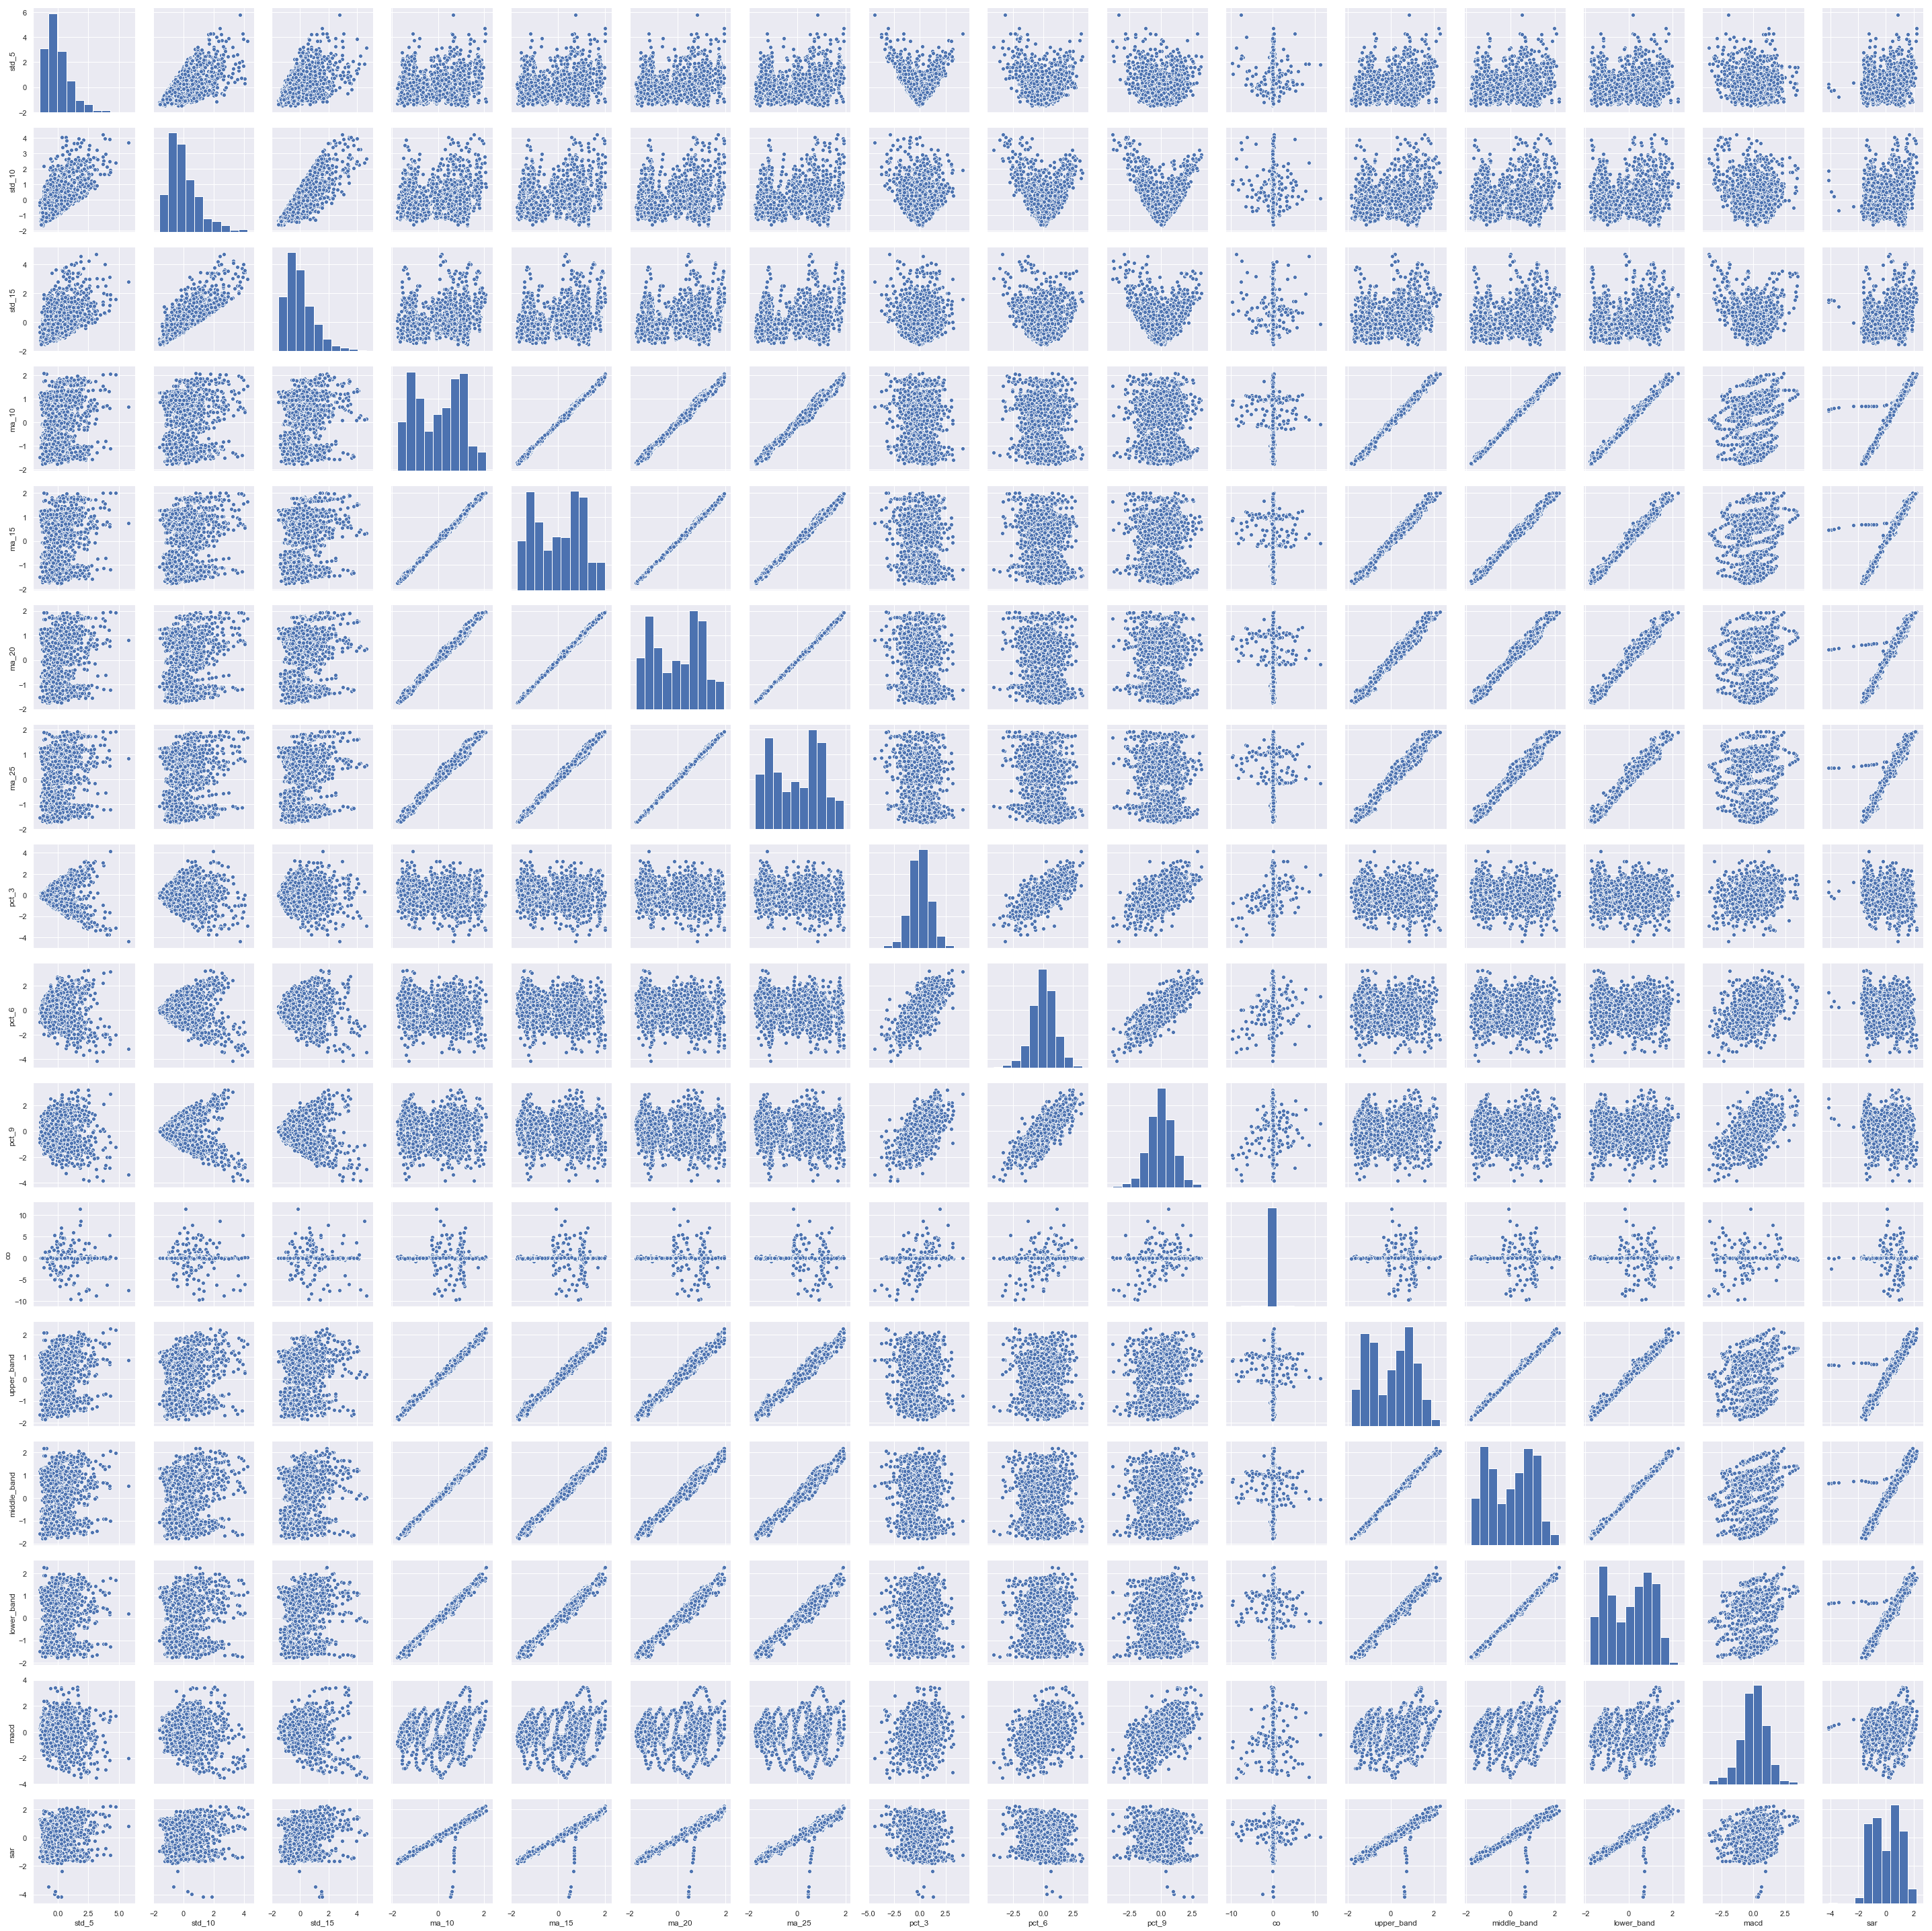

In [49]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
sns.pairplot(X_train_scaled_df[features_list]);

In [50]:
X_train_scaled_df.describe().round(2).T

count  mean  std   min   25%   50%   75%    max
std_5        1848.0  -0.0  1.0 -1.48 -0.72 -0.24  0.45   5.77
std_10       1848.0   0.0  1.0 -1.63 -0.74 -0.23  0.50   4.24
std_15       1848.0   0.0  1.0 -1.54 -0.72 -0.23  0.48   4.70
ma_10        1848.0   0.0  1.0 -1.77 -0.97  0.07  0.85   2.09
ma_15        1848.0  -0.0  1.0 -1.76 -0.98  0.08  0.84   2.00
ma_20        1848.0   0.0  1.0 -1.74 -0.99  0.09  0.85   1.95
ma_25        1848.0  -0.0  1.0 -1.72 -1.00  0.10  0.85   1.91
pct_3        1848.0   0.0  1.0 -4.41 -0.57 -0.01  0.61   4.17
pct_6        1848.0   0.0  1.0 -4.15 -0.60 -0.01  0.61   3.24
pct_9        1848.0  -0.0  1.0 -3.81 -0.63  0.03  0.63   3.20
co           1848.0   0.0  1.0 -9.74 -0.03  0.01  0.06  11.39
upper_band   1848.0   0.0  1.0 -1.83 -0.96  0.07  0.85   2.28
middle_band  1848.0  -0.0  1.0 -1.79 -0.96  0.06  0.86   2.18
lower_band   1848.0  -0.0  1.0 -1.79 -0.97  0.07  0.87   2.27
macd         1848.0   0.0  1.0 -3.50 -0.57  0.05  0.66   3.46
sar          1848.0   0.0  1.0 -4.17 -0.90  0.07  0.85   2.22

We have everything ready now. Now is the time to create our first neural network. We'll use the `MLPClassifier` from the `sklearn.neural_network` package. Here, MLP stands for Multi Layer Perceptron. A simple neural network is shown below:

![Neural Network](https://www.learnopencv.com/wp-content/uploads/2017/10/mlp-diagram-600x400.jpg)

We can see that a neural network consists of

- Input layer,
- Hidden layer, and 
- Output layer

Hence, we need to define these layers for the model. In our case, the feature matrix `X` becomes input to the input layer. Then we have hidden layer/s and finally the output layer. In the above diagram, we have only one hidden layer.

    Note: In `sklearn` library, we need not specify the size of the input and output layer. It will be fixed by the library itself when we train it. Hence, we are only to define hidden layer sizes.

Below we define the model:

In [20]:
from sklearn.neural_network import MLPClassifier

In [21]:
# Define model
model = MLPClassifier(hidden_layer_sizes=(5), verbose=True, random_state=10)

# Train model
model.fit(X_train_scaled, y_train)

Iteration 1, loss = 0.76277156
Iteration 2, loss = 0.74514280
Iteration 3, loss = 0.73180038
Iteration 4, loss = 0.72205305
Iteration 5, loss = 0.71504687
Iteration 6, loss = 0.71069688
Iteration 7, loss = 0.70709655
Iteration 8, loss = 0.70433689
Iteration 9, loss = 0.70255064
Iteration 10, loss = 0.70102112
Iteration 11, loss = 0.69969502
Iteration 12, loss = 0.69848917
Iteration 13, loss = 0.69782385
Iteration 14, loss = 0.69715620
Iteration 15, loss = 0.69660396
Iteration 16, loss = 0.69591397
Iteration 17, loss = 0.69560418
Iteration 18, loss = 0.69507801
Iteration 19, loss = 0.69469143
Iteration 20, loss = 0.69432210
Iteration 21, loss = 0.69411152
Iteration 22, loss = 0.69395887
Iteration 23, loss = 0.69363077
Iteration 24, loss = 0.69345981
Iteration 25, loss = 0.69315142
Iteration 26, loss = 0.69301952
Iteration 27, loss = 0.69282352
Iteration 28, loss = 0.69263928
Iteration 29, loss = 0.69253165
Iteration 30, loss = 0.69242937
Iteration 31, loss = 0.69221736
Iteration 32, los

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=5, learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=10, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=True, warm_start=False)

Congratulations, we have successfully trained our first neural network. Now let's check its properties

In [22]:
# Check number of layers in the model
model.n_layers_

3

In [23]:
# Check weights
print('Weights between input layer and the hidden layer:')
print(model.coefs_[0])

Weights between input layer and the hidden layer:
[[ 0.16629788 -0.50711819  0.10417646  0.49088915 -0.00272593]
 [-0.2758769  -0.26006799  0.30347027 -0.35585579 -0.39800752]
 [ 0.10484291  0.4088167  -0.44384473  0.13022843  0.34985668]
 [ 0.08987299  0.15588969 -0.24526451  0.50619012  0.28422592]
 [ 0.01746895 -0.4596772  -0.15482863  0.24045843 -0.00752731]
 [-0.11068389  0.04781903 -0.01376388  0.2245374   0.17457554]
 [ 0.28322388 -0.05552636  0.40849286 -0.12194808 -0.35887151]
 [-0.05150178 -0.47166015  0.2627345  -0.54852956  0.0977572 ]
 [ 0.14642251  0.33682554 -0.33563564  0.36832303 -0.26720168]
 [ 0.21099059 -0.28207479  0.26488842 -0.13414997 -0.37023943]
 [-0.04893866 -0.43140204  0.04818775 -0.42854286 -0.19861007]
 [ 0.43274731  0.43186718 -0.07786804  0.4271052  -0.21039985]
 [ 0.06825344  0.33947287  0.00732863  0.16437996 -0.43686324]
 [-0.1817335  -0.54222838 -0.23593846 -0.12395123  0.34854184]
 [-0.32887369  0.04809214 -0.10085683 -0.12033318 -0.36286927]
 [-0.

In [24]:
print('Weights between hidden layer and the output layer:')
print(model.coefs_[1])

Weights between hidden layer and the output layer:
[[-0.6992764 ]
 [-0.37352361]
 [-0.30607825]
 [ 0.20103657]
 [ 0.19901444]]


In [25]:
# Check model accuracy on training data
print('Model accuracy on training data:', model.score(X_train_scaled, y_train))

Model accuracy on training data: 0.525974025974026


In [26]:
# Check model accuracy on testing data
print('Model accuracy on testing data:', model.score(X_test_scaled, y_test))

Model accuracy on testing data: 0.474025974025974


In [27]:
X_train_scaled

array([[ 1.62501763,  2.715167  ,  3.46093502, ...,  0.96900517,
         2.82488142,  0.87817393],
       [-0.95455315, -0.3450743 , -0.73885811, ..., -0.55636776,
         0.00609832, -0.69254797],
       [-0.1988205 ,  0.27185989, -0.41284382, ...,  1.66860649,
         1.52052399,  1.52420743],
       ...,
       [-0.97380667, -0.8011192 , -0.73429694, ...,  0.92037172,
        -0.87045162,  0.98255846],
       [-0.95568629, -1.09215749, -0.76539318, ..., -0.03441011,
         0.06053175, -0.13459686],
       [ 0.75062128,  0.44174872, -0.19191485, ...,  0.44843979,
        -0.28373427,  0.3189473 ]])

In [28]:
model.predict_proba(X_test_scaled)

array([[0.4925646 , 0.5074354 ],
       [0.45546545, 0.54453455],
       [0.48829624, 0.51170376],
       [0.63198422, 0.36801578],
       [0.48725052, 0.51274948],
       [0.49418066, 0.50581934],
       [0.44517146, 0.55482854],
       [0.48478949, 0.51521051],
       [0.51819065, 0.48180935],
       [0.49705148, 0.50294852],
       [0.50454053, 0.49545947],
       [0.45963624, 0.54036376],
       [0.37947926, 0.62052074],
       [0.52806823, 0.47193177],
       [0.57170459, 0.42829541],
       [0.53755095, 0.46244905],
       [0.50357778, 0.49642222],
       [0.4808822 , 0.5191178 ],
       [0.49045971, 0.50954029],
       [0.49633765, 0.50366235],
       [0.51247978, 0.48752022],
       [0.3683331 , 0.6316669 ],
       [0.30123828, 0.69876172],
       [0.48180616, 0.51819384],
       [0.5312802 , 0.4687198 ],
       [0.54075363, 0.45924637],
       [0.54708517, 0.45291483],
       [0.50472188, 0.49527812],
       [0.57566863, 0.42433137],
       [0.48251055, 0.51748945],
       [0.

As training and testing accuracy are very similar, we can consider that model might not have overfitted, and it can generalize well. However, it is difficult to claim until we are test it on validation set/s.

Also, the model that we have created is a very simple one; we have used most of the default parameters for building the model. And they might not be the best one. 

## Part 2 - Backtesting our predictions

So far we've covered
* Read Data
* Create Features
* Train data
* Use already trained data to make predictions
* Trade on those prediction, and calculate the strategy returns

In [57]:
def backtest(df, model):
    # Copy data
    data = df.copy()
    
    # Create returns
    data['returns'] = np.log(data['Close'] / data['Close'].shift(1))
    # Creating features
    features_list = []

    # SD based features
    for i in range(5, 20, 5):
        col_name = 'std_' + str(i)
        data[col_name] = data['Close'].rolling(window=i).std()
        features_list.append(col_name)

    # MA based features
    for i in range(10, 30, 5):
        col_name = 'ma_' + str(i)
        data[col_name] = data['Close'].rolling(window=i).mean()
        features_list.append(col_name)

    # Daily pct change based features
    for i in range(3, 12, 3):
        col_name = 'pct_' + str(i)
        data[col_name] = data['Close'].pct_change().rolling(i).sum()
        features_list.append(col_name)

    # Intraday movement
    col_name = 'co'
    data[col_name] = data['Close'] - data['Open']
    features_list.append(col_name)
    # Create features
    data['upper_band'], data['middle_band'], data['lower_band'] = ta.BBANDS(data['Close'].values)
    data['macd'], data['macdsignal'], data['macdhist'] = ta.MACD(data['Close'].values)
    data['sar'] = ta.SAR(data['High'].values, data['Low'].values)
    features_list +=['upper_band','middle_band','lower_band','macd','sar']
    # Create target
    data['target'] = np.where(data['Close'].shift(-1) > data['Close'], 1, -1)
    
    # Drop null values
    data.dropna(inplace=True)
    
    # Create feature matrix and target vector
    X = data[features_list]
    y = data['target']
    
    # Scale data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Predict
    y_pred = model.predict(X_scaled)
    
    data['predicted'] = y_pred
    
    # Create strategy returns
    data['strategy_returns'] = data['returns'].shift(-1) * data['predicted']
    
    # Return the last cumulative return
    bnh_returns = data['returns'].cumsum()[-1]
    
    # Return the last cumulative strategy return
    # we need to drop the last nan value
    data.dropna(inplace=True)
    strategy_returns = data['strategy_returns'].cumsum()[-1]
    
    plt.figure(figsize=(10, 6))
    plt.plot(data['returns'].cumsum())
    plt.plot(data['strategy_returns'].cumsum())
    plt.xlabel('Time')
    plt.ylabel('Cumulative Returns')
    plt.title('Returns Comparison')
    plt.legend()
    plt.show()
    
    return bnh_returns, strategy_returns

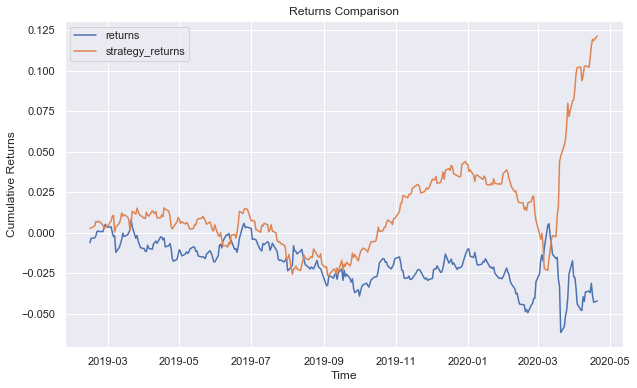

Buy and Hold Returns: -0.04493700231567206
Strategy Returns: 0.12155136671237418


In [58]:
# Read backtest data
backtest_data = pd.read_csv('EURUSD_backtest.csv', index_col=0, parse_dates=True)
# Backtest the strategy
bnh_returns, s_returns = backtest(backtest_data, model)

print('Buy and Hold Returns:', bnh_returns)
print('Strategy Returns:', s_returns)

Backtesting on the the best classifier.

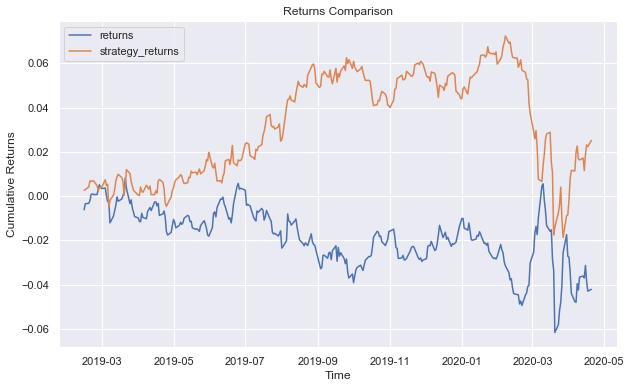

Buy and Hold Returns: -0.04493700231567206
Strategy Returns: 0.025156102717939662


In [59]:
bnh_returns, s_returns = backtest(backtest_data, clf.best_estimator_)

print('Buy and Hold Returns:', bnh_returns)
print('Strategy Returns:', s_returns)